In [ ]:
import numpy as np
import cupy as cp
import jax
import jax.numpy as jnp

# **Entropy**
---

## Numpy loop

In [ ]:
def nb_ent_g(x):
    nvarx, ntrl = x.shape

    # covariance
    c = np.dot(x, x.T) / float(ntrl - 1)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.sum(np.log(np.diag(chc))) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)
    return hx

def entropy_loop(x):
    h = []
    for k in range(x.shape[0]):
        h.append(nb_ent_g(x[k, ...]))
    return h

## Numpy tensor

In [ ]:
def nb_ent_g_nd(x):
    _, nvarx, ntrl = x.shape
    
    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)
    return hx

## Jax tensor

In [ ]:
@jax.jit
def jnb_ent_g_nd(x):
    _, nvarx, ntrl = x.shape

    # covariance
    c = jnp.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = jnp.linalg.cholesky(c)

    # entropy in nats
    hx = jnp.log(jnp.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        jnp.log(2 * jnp.pi) + 1.0)
    return hx

## Benchmark

In [ ]:
x = 1000 * np.random.rand(20, 4, 600)
xj = jnp.asarray(x)

print("Loop")
%timeit -n 1000 entropy_loop(x)

print("Tensor (NumPy)")
%timeit -n 1000 nb_ent_g_nd(x)

print("Tensor (JAX)")
xj = jnp.asarray(x)
%timeit -n 1000 jnb_ent_g_nd(xj).block_until_ready()


Loop
735 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensor (NumPy)
212 µs ± 7.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensor (JAX)
158 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# **O-info**
---

## Numpy loop

In [ ]:
def oinfo_np_loop(x):
    nvars, _ = x.shape

    # (n - 2) * H(X^n)
    o = (nvars - 2) * nb_ent_g(x)

    for j in range(nvars):
        # sum_{j=1...n}( H(X_{j}) - H(X_{-j}^n) )
        o += nb_ent_g(x[[j], :]) - nb_ent_g(np.delete(x, j, axis=0))

    return o


## Numpy tensor

In [ ]:
def oinfo_np_tensor(x, ind):
    nvars, _ = x.shape
    o = (nvars - 2) * nb_ent_g(x)
    o += (nb_ent_g_nd(x[:, np.newaxis, :]) - nb_ent_g_nd(x[ind[:, 1:], :])).sum(0)
    return o


## Jax tensor

In [ ]:
@jax.jit
def oinfo_jax_tensor(x, ind):
    nvars, _ = x.shape
    o = (nvars - 2) * jnb_ent_g_nd(x[np.newaxis, ...])
    o += (jnb_ent_g_nd(x[:, np.newaxis, :]) -
          jnb_ent_g_nd(x[ind[:, 1:], :])).sum(0)
    return o

## Benchmark

In [ ]:
x = np.random.rand(3, 5)

nvars = x.shape[0]

ind = np.zeros((nvars, nvars), dtype=int)
vec = np.arange(nvars)
for k in range(nvars):
    ind[k, :] = np.roll(vec, -k)

xjax = jnp.asarray(x)
indjax = jnp.asarray(ind)

n = 300

In [ ]:

print('LOOP :')
%timeit -n 300 oinfo_np_loop(x)

print('\nTensor (NUMPY) :')
%timeit -n 300 oinfo_np_tensor(x, ind)

print('\nTensor (JAX) :')
%timeit -n 300 oinfo_jax_tensor(xjax, indjax).block_until_ready()


LOOP :


NameError: ignored

## Simulations

In [ ]:
!pip install frites

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 32.3 MB/s 


In [ ]:
"""Dynamic and task-related higher-order interactions."""
import numpy as np
import xarray as xr

import itertools

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.utils import parallel_func
from frites.core import copnorm_nd
import matplotlib.pyplot as plt
from frites import set_mpl_style
import seaborn as sns

set_mpl_style()


Bad key "legend.labelcolor" on line 43 in
/usr/local/lib/python3.7/dist-packages/frites/data/frites.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:

def ent_g(x):
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)
    return hx


def compute_oinfo(x, ind):
    """Compute the O-info.

    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x)
    o += (ent_g(x[..., np.newaxis, :]) - ent_g(x[..., ind, :])).sum(1)
    return o


def combinations(n, k, roi, task_related=False):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    roi_st = ['-'.join(r) for r in roi[combs].tolist()]

    return combs, roi_st


def conn_hoi(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.

    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :

            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)

    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets

    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        for mult in combs:
            _oinfo = compute_oinfo(x[:, mult, :], ind)
            oinfo += [_oinfo]
    oinfo = np.stack(oinfo, 0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo



In [ ]:
# functions to define redundancy and synergy
def set_redundancy(x, redundancy, sl, win, trials):
    for m in redundancy:
        x[:, m, sl] += .6 * trials.reshape(-1, 1, 1) * win
    return x

def set_lin_relationship(x, relationships, sl, win):
  # last item is the dependent var
  for r in relationships:
    x[:, r[-1], sl] += np.sum(x[:, r[:-1],sl], axis=1)*win         
  return x


def set_synergy(x, synergy, sl, win, trials):
    for m in synergy:
        blocks = np.array_split(np.arange(n_trials), len(m))
        for n_b, b in enumerate(blocks):
            x[b, m[n_b], sl] += trials[b].reshape(-1, 1) * win[0, ...]
    return x

In [ ]:
def generate_data(n_trials=300, n_roi=6, n_times=600, alpha=0.6):
    # generate the data
    x = np.random.rand(n_trials, n_roi, n_times)
    roi = np.array([f"r{r}" for r in range(n_roi)])
    trials = np.random.rand(n_trials)
    # trials = np.arange(n_trials)
    # times = (np.arange(n_times) - 200) / 128.
    times = np.arange(n_times)
    win = np.hanning(100).reshape(1, -1)
    win = alpha*win

    return x, trials, times, roi, win


In [ ]:

def plot_oinfo(oinfo, relationships):
  # print(oinfo)
  vmin, vmax = np.nanpercentile(oinfo.data, [1, 99])
  minmax = max(abs(vmin), abs(vmax))
  vmin, vmax = -minmax, minmax

  # plot the results
  df = oinfo.to_pandas()
  plt.pcolormesh(
      df.columns, df.index, df.values, cmap='RdBu_r', vmin=vmin, vmax=vmax
  )
  plt.colorbar()
  plt.xlabel('Times')
  plt.axvline(0., color='k')

  rel = ['-'.join(roi[list(r)]) for r in relationships]
  # syn = ['-'.join(roi[list(r)]) for r in synergy]
  for n_k, k in enumerate(oinfo['roi'].data):
      if k.replace('-beh', '') in rel:
          plt.gca().get_yticklabels()[n_k].set_color('red')
      # if k.replace('-beh', '') in syn:
      #     plt.gca().get_yticklabels()[n_k].set_color('blue')

  plt.show()

### Linear relationship: Pure synergy

Defining links (n_roi=6; directed=False; net=False, nb_min_links=None)
INFO:frites:Defining links (n_roi=6; directed=False; net=False, nb_min_links=None)
    Sorting roi names
INFO:frites:    Sorting roi names
Compute the  HOI (min=3; max=5)
INFO:frites:Compute the  HOI (min=3; max=5)
    Copnorm the data
INFO:frites:    Copnorm the data
    Multiplets of size 3
INFO:frites:    Multiplets of size 3
    Multiplets of size 4
INFO:frites:    Multiplets of size 4
    Multiplets of size 5
INFO:frites:    Multiplets of size 5


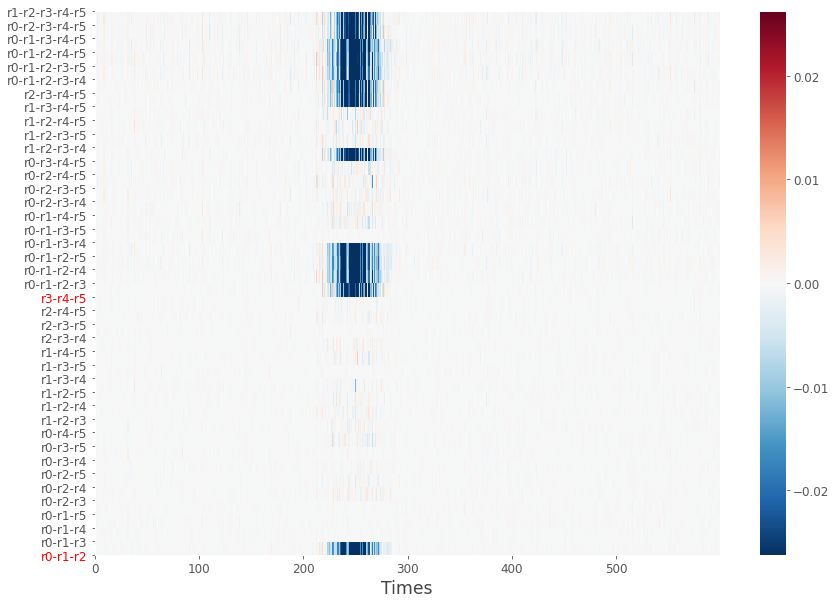

In [ ]:
###########################################################################
n_trials = 300
n_roi = 6
n_times = 600
# win amplitude
alpha = 0.6 

# the last item is the dependent var
# ex: (0,1,2) => X_2 = X_0 + X_1
relationships = [
    (0, 1, 2),
    (3, 4, 5),
]
###########################################################################

# generate and setup data
x,trials,times, roi, win = generate_data(n_trials, n_roi, n_times, alpha)
x = set_lin_relationship(x, relationships, slice(200,300), win)
    
x = xr.DataArray(x, dims=('trials', 'roi', 'times'),
                     coords=(trials, roi, times))

# compute o-info
oinfo = conn_hoi(x, minsize=3, maxsize=5, y=None, roi='roi',
                  times='times')

# plot
plot_oinfo(oinfo, relationships)

# introduce (redundant, synergistic) information
# x = set_redundancy(x, redundancy, slice(200, 300), win, trials)
# x = set_lin_relationship(x, relationships, slice(200, 300), win)
# x = set_synergy(x, synergy, slice(300, 400), win, trials)    

### Linear relationship: Synergy + Redundancy

Defining links (n_roi=6; directed=False; net=False, nb_min_links=None)
INFO:frites:Defining links (n_roi=6; directed=False; net=False, nb_min_links=None)
    Sorting roi names
INFO:frites:    Sorting roi names
Compute the  HOI (min=3; max=5)
INFO:frites:Compute the  HOI (min=3; max=5)
    Copnorm the data
INFO:frites:    Copnorm the data
    Multiplets of size 3
INFO:frites:    Multiplets of size 3
    Multiplets of size 4
INFO:frites:    Multiplets of size 4
    Multiplets of size 5
INFO:frites:    Multiplets of size 5


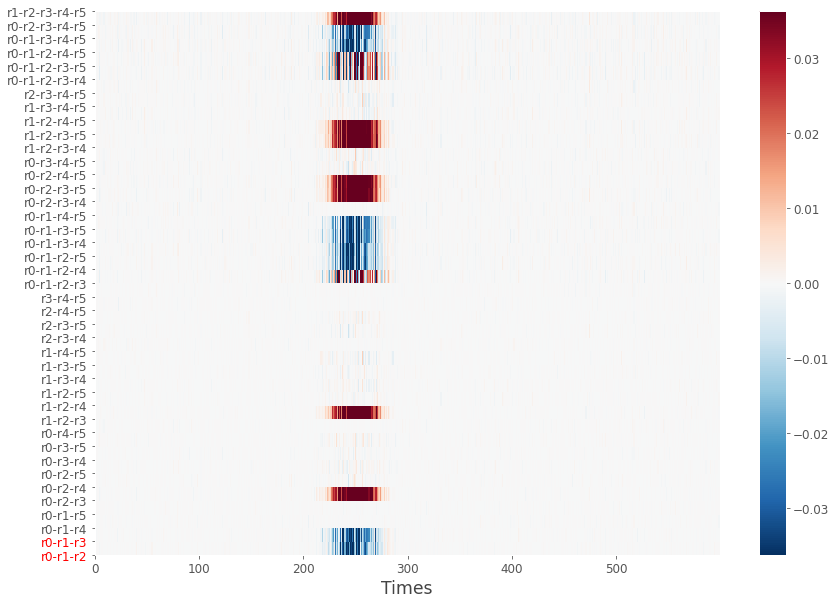

In [ ]:
###########################################################################
n_trials = 300
n_roi = 6
n_times = 600
# win amplitude
alpha = 0.6 

# the last item is the dependent var
# ex: (0,1,2) => X_2 = X_0 + X_1
relationships = [
    (0, 1, 2),
    (0, 1, 3),
]
###########################################################################

# generate and setup data
x,trials,times, roi, win = generate_data(n_trials, n_roi, n_times, alpha)
x = set_lin_relationship(x, relationships, slice(200,300), win)
    
x = xr.DataArray(x, dims=('trials', 'roi', 'times'),
                     coords=(trials, roi, times))

# compute o-info
oinfo = conn_hoi(x, minsize=3, maxsize=5, y=None, roi='roi',
                  times='times')

# plot
plot_oinfo(oinfo, relationships)